# Neural Ordinary Differential Equations

На конференции NIPS 2019 года была представлена статья,
которая называется 'Нейронные обычные дифференциальные уравнения'.
Эта статья была в числе 4 из 4854 статей, которая получила награду
'Best paper'. В своей работе я постараюсь разобрать метод, предлагаемый
авторами и сравнить данную архитектуру с уже существующими решениями

### Вступление

Что происходит в обычных нейронных сетях? В них есть слои(скрытые состояния) $ h_t $ и переходы между этими состояниями
 происходят с помощью умножений на соответствующие матрицы весов $ W_t $.
<img src=assets/mlp.png width=600 ></img>

У остаточных нейронных сетей принцип действия такой же, за исключением того, что на выходе из слоя добавляется
еще и исходное состояние: <img src=assets/res_learn.png width=600 ></img>

Идея этого заключается в том, что мы не очень хотим чтобы наше состояние кардинально отличалось от
предыдущего на каждом шаге.

Состояния остаточных нейронных сетей описываются следующей формулой: $h_{t+1} = h_{t} + f(h_{t}, \theta_{t})$, где $t \in \{0...T\}$ -
это номер блока, $ \theta_t $ - матрица весов, а $f $ - функция активации соответствующего слоя.

А что если $ T $ устремить к бесконечности, а $ t_{i} - t_{i-1} $ , то есть, шаг, устремить к нулю?
Тогда это можно рассматривать как некий временной процесс.
Следовательно, это можно записать в виде дифференциального уравнения: $\frac{dh(t)}{dt} = f(h(t), t, \theta)$

Тогда, решая это дифференциальное уравнение можно восстановить искомую зависимость.


Как решать такое дифференциальное уравнение?
В исходной статье используется метод Эйлера. Как он работает: <img src=https://github.com/AlexKrudu/NeuralODE/blob/featureDiffeq/assets/euler.jpg?raw=1 width=600 ></img>
Численное решение задается формулой $ y_i = y_{i -1} + hf(x_{i-1}, y_{i -1}) $

То есть, на каждой итерации мы делаем маленький шаг в сторону градиента функции. В конечном итоге
после всех итераций мы восстановим искомую функцию.

Обучение такой нейронной сети заключается в том, что нам необходимо найти такие веса $ \theta $ , чтобы
получить правильные градиенты $\frac{dh(t)}{dt} $ такие, что когда мы решаем ОДУ, мы получим правильную функцию
, которая в конечный момент времени $ t $ , то есть, на выходном
слое выдаст правильный ответ с желаемой точностью.

#### Как мы будем обучать такую нейросеть?

Наша нейросеть определяет переходы от одного состояния к следующему. У нее есть параметры $ \theta $ , которые
нам и нужно обучить. А обучать мы их будем с помощью обычного градиентного спуска, прямо как в
классической нейронной сети. Но не все так просто.

<img src=assets/loss.png width=600 ></img>

Функция потери в свою очередь задается следующим образом:
$ L(z(t_1)) = L(z(t_0) + \int_{t_0}^{t_1} f(z(t), t, \theta) dt) = L(ODESolve(z(t_0), f, t_0, t_1, \theta))  $

Таким образом, чтобы оптимизировать $ L $ нам нужны произодные $ \frac{dL}{d\theta} $ .
Чтобы это сделать нужно определить как функция потерь зависит от $ z(t) $ в каждый момент.
Эта зависимость обозначается как $ a(t) = \frac{dL}{dz(t)} $ и называется *сопряженным* состоянием.

Тогда получим: $ \frac{d a(t)}{d t} = -a(t) \frac{\partial f(z(t), t, \theta)}{\partial z}
 $ (вывод этой формулы можно посмотреть в оригинальной статье).

Решая этот дифур можно получить все необходимые частные производные:

$
\frac{\partial L}{\partial z(t_0)} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial z} dt
$

$
\frac{\partial L}{\partial \theta} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial \theta} dt
$

$
\frac{\partial L}{\partial t_0} = \int_{t_1}^{t_0} a(t) \frac{\partial f(z(t), t, \theta)}{\partial t} dt
$

Все эти частные производные могут быть посчитаны за один вызов ODESolve:
<img src=assets/algo.png width=600 ></img>

### Практика

Авторы статьи говорят, что такая архитектура требует константной памяти, адаптирует стратегию вычисления
к каждым входным данным и позволяет выгодно обменивать численную точность на скорость

Это звучит впечатляюще, но так ли оно на самом деле?

Посмотрим как данная архитектура справится с восстановлением зависимости, заданной системой дифференциальных
уравнений и сравним ее результат с классической архитектурой.

In [ ]:
!git clone https://github.com/rtqichen/torchdiffeq.git

Cloning into 'torchdiffeq'...
remote: Enumerating objects: 300, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 1004 (delta 175), reused 275 (delta 162), pack-reused 704
Receiving objects: 100% (1004/1004), 8.22 MiB | 29.03 MiB/s, done.
Resolving deltas: 100% (601/601), done.


In [ ]:
!cd torchdiffeq && pip install -e .

Obtaining file:///content/torchdiffeq
  Running setup.py develop for torchdiffeq


In [ ]:
import os
import time
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchdiffeq.torchdiffeq import odeint
#from torchdiffeq import odeint
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
batch_time = 10
batch_size = 20
data_size = 200

viz = True

def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_y0 = true_y[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_y = torch.stack([true_y[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_y0, batch_t, batch_y


def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

DATA_TYPE = 'NNET_MORE'

if viz:
    makedirs(DATA_TYPE)
    import matplotlib.pyplot as plt

def visualize(true_y, pred_y, odefunc, itr):

    if viz:

        plt.figure()
        plt.plot(t.numpy(), true_y.numpy()[:, 0, 0], t.numpy(), true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(t.numpy(), pred_y.numpy()[:, 0, 0], '--', t.numpy(), pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/ts' + str(itr) + '.png')
        plt.show()

        plt.figure()
        plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
        plt.plot(pred_y.numpy()[:, 0, 0], pred_y.numpy()[:, 0, 1], 'b--')
        plt.savefig(DATA_TYPE + '/phase' + str(itr) + '.png')
        plt.show()

In [ ]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val

Зададим систему дифференциальных уравнений следующего вида:
$Y' = AY$ где $A = \begin{bmatrix}
a & b \\
c & d \end{bmatrix}$ и $Y$ = $\begin{bmatrix} y_1 (t) \\ y_2 (t)
\end{bmatrix}$

Пусть $A = \begin{bmatrix}
0 & -2 \\
2 & 0
\end{bmatrix}$
и $Y(0) = \begin{bmatrix}
2 \\
0
\end{bmatrix}$
Тогда решая систему получим
$ Y = \begin{bmatrix}
2\cos(t) \\
2\sin(t)
\end{bmatrix} $, оно же является параметрическим уравнением эллипса.
На самом деле, можно еще поиграть со значениями матрицы $A$ , например, чтобы получился не эллипс, а спираль.

In [ ]:
true_y0 = torch.tensor([[2., 0.]])
t = torch.linspace(0., 25., 1000)
true_A = torch.tensor([[0, -2.], [2., 0]])

class Lambda(nn.Module):

    def forward(self, t, y):
        return torch.mm(y, true_A)

with torch.no_grad():
    true_y = odeint(Lambda(), true_y0, t, method='dopri5')
    print(true_y.shape)

torch.Size([1000, 1, 2])


На самом деле, метод Эйлера решения дифференциальных уравнений является довольно неточным, но, к счастью,
 прогресс не стоит на месте.
Поэтому, внутри функции *odeint* реализованы более
сложные методы решения. Сейчас выведем на плоскость решение этой системы дииференциальных уравнений.
Напомню, что должен получиться эллипс.

(1000, 1, 2)


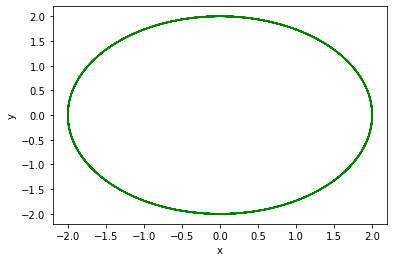

In [ ]:
ellips = plt.figure()
print(true_y.numpy().shape)
plt.plot(true_y.numpy()[:, 0, 0], true_y.numpy()[:, 0, 1], 'g-')
plt.xlabel("x")
plt.ylabel("y")
ellips.show()

Да, получился ровно эллипс.

Далее создадим модель, которую будем обучать. Она будет совсем простой.

In [ ]:
class ODEFunc(nn.Module):

    def __init__(self):
        super(ODEFunc, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 150),
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

In [ ]:
ii = 0
niters = 5000

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)

for itr in range(1, niters + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    #print(batch_t.shape)
    pred_y = odeint(func, batch_y0, batch_t)
    #with torch.no_grad():
        #print(true_y.numpy().shape, batch_t.numpy().shape)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    time_meter.update(time.time() - end)
    loss_meter.update(loss.item())

    if itr % 50 == 0:
        with torch.no_grad():
            pred_y = odeint(func, true_y0, t)
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()

torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])
torch.Size([10])


KeyboardInterrupt: ignored

Теперь обучим нейросеть состоящую из такого же набора слоев, но без использования odenet.

In [ ]:
class Func(nn.Module):

    def __init__(self):
        super(Func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(1, 150), # на входе - параметр t, на выходе значения x(t), y(t)
            nn.Tanh(),
            nn.Linear(150, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 2),
        )

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t):
        return self.net(t)

Iter 0050 | Total Loss 1.285179


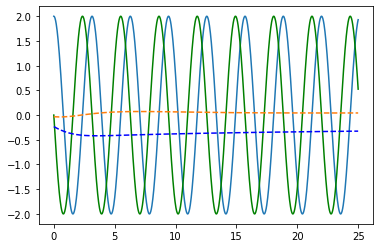

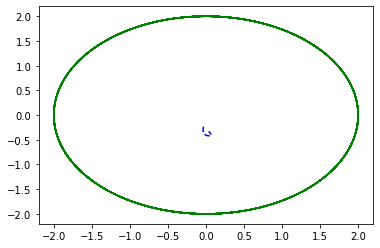

Iter 0100 | Total Loss 1.045247


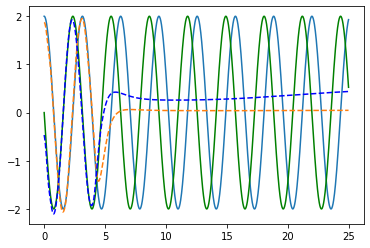

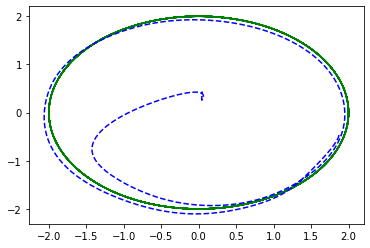

Iter 0150 | Total Loss 0.934123


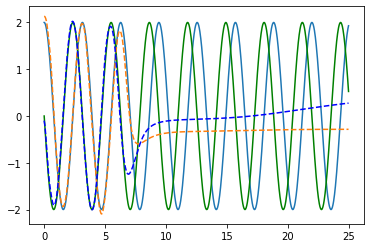

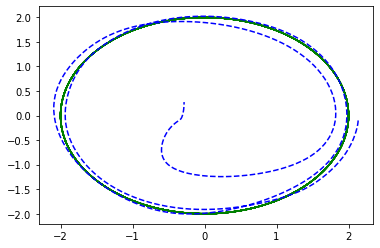

Iter 0200 | Total Loss 0.864075


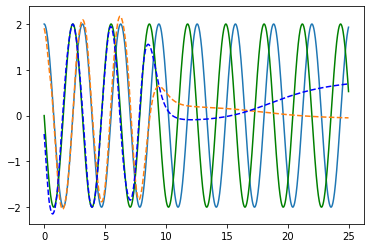

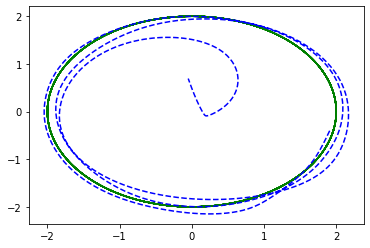

Iter 0250 | Total Loss 0.821850


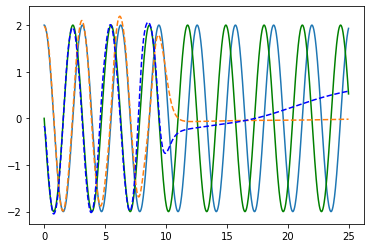

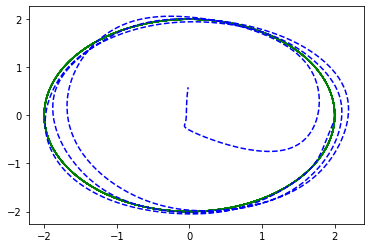

Iter 0300 | Total Loss 0.780273


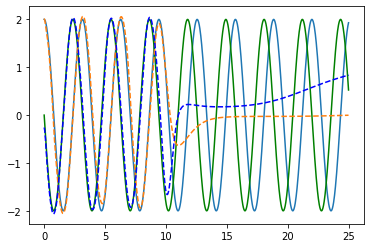

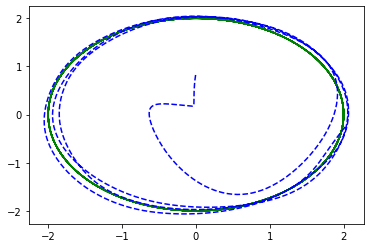

Iter 0350 | Total Loss 0.762716


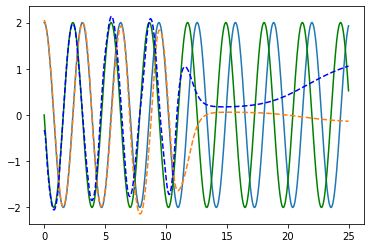

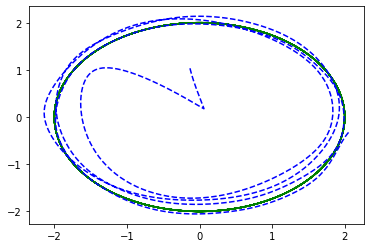

Iter 0400 | Total Loss 0.728913


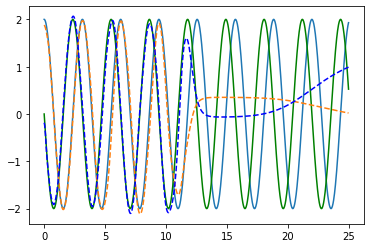

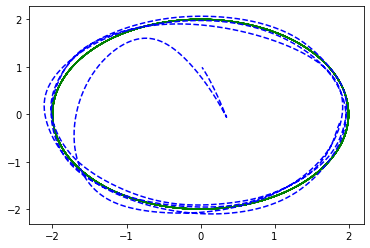

Iter 0450 | Total Loss 0.699540


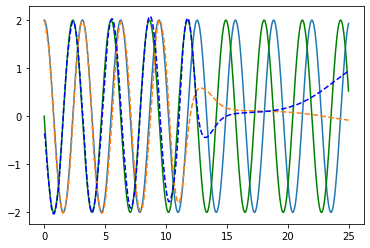

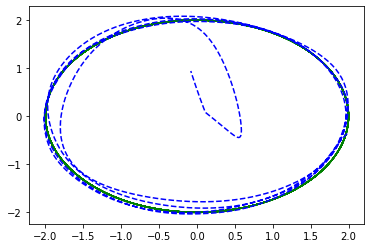

Iter 0500 | Total Loss 0.681836


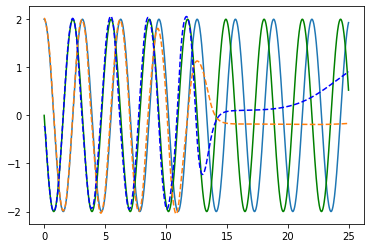

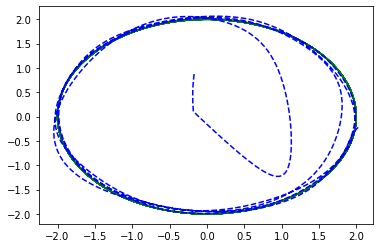

Iter 0550 | Total Loss 0.733198


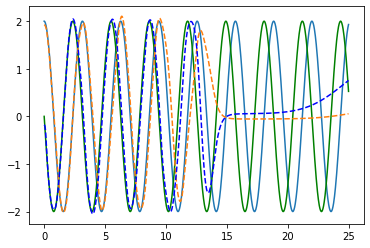

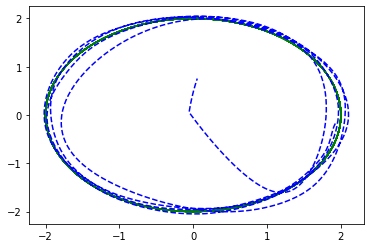

Iter 0600 | Total Loss 0.644874


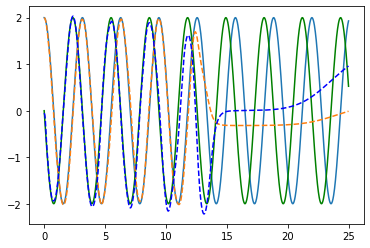

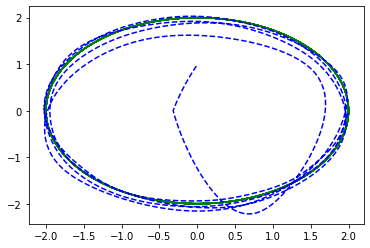

Iter 0650 | Total Loss 0.643306


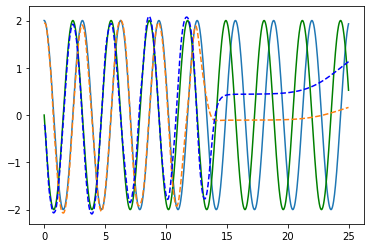

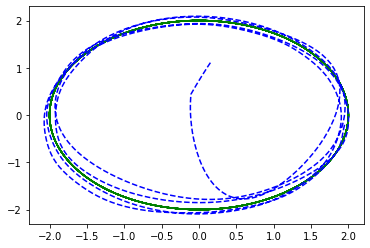

Iter 0700 | Total Loss 0.646319


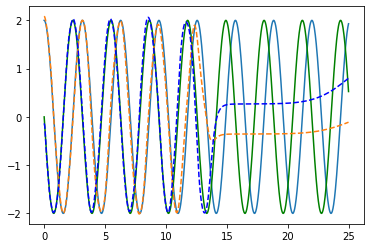

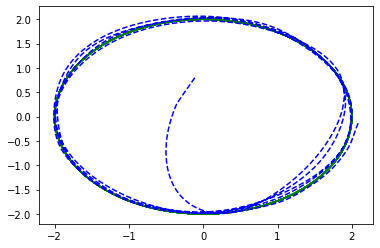

Iter 0750 | Total Loss 0.615616


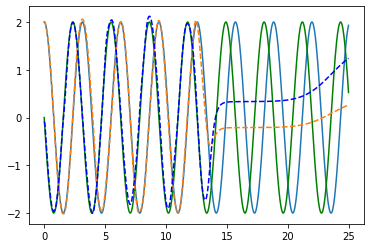

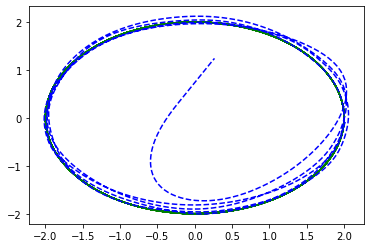

Iter 0800 | Total Loss 0.654200


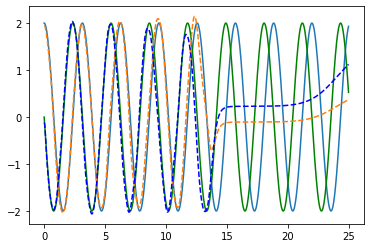

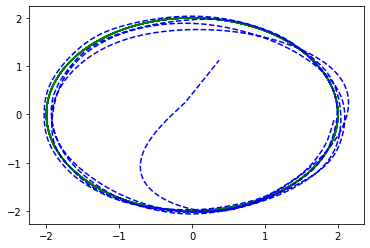

Iter 0850 | Total Loss 0.650582


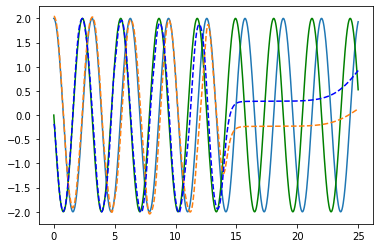

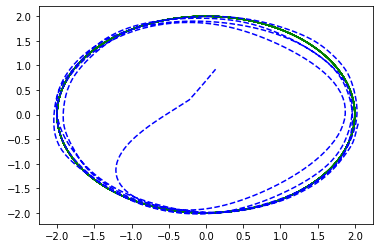

Iter 0900 | Total Loss 0.616025


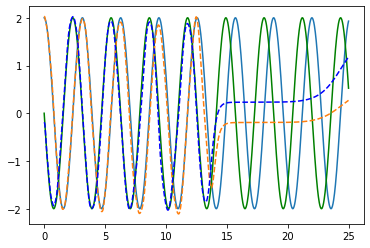

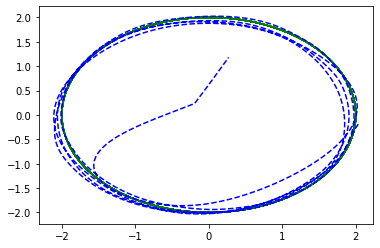

Iter 0950 | Total Loss 0.649533


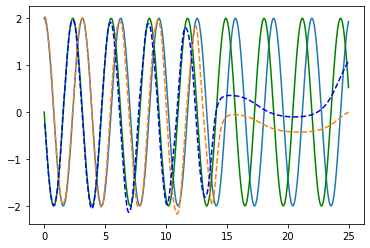

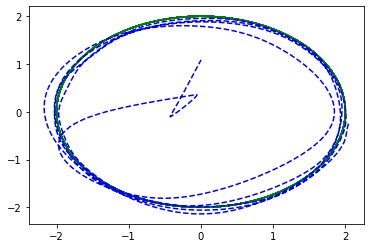

Iter 1000 | Total Loss 0.601279


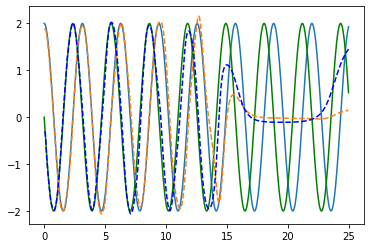

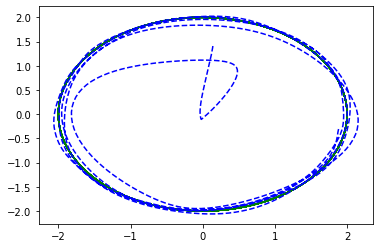

Iter 1050 | Total Loss 0.571910


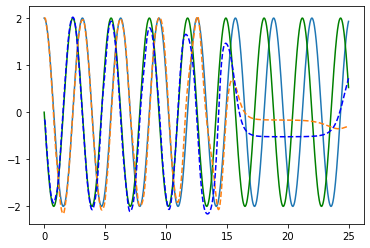

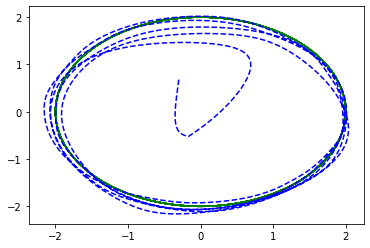

Iter 1100 | Total Loss 0.554241


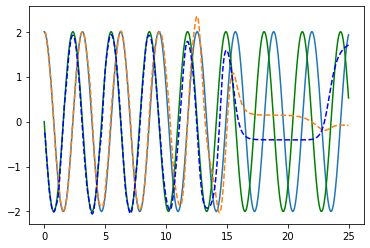

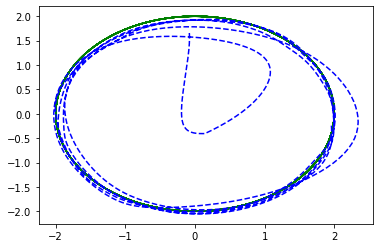

Iter 1150 | Total Loss 0.520306


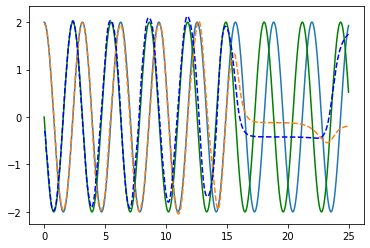

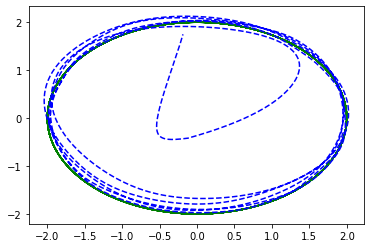

Iter 1200 | Total Loss 0.514002


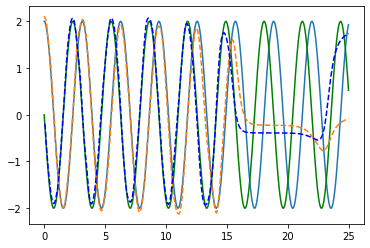

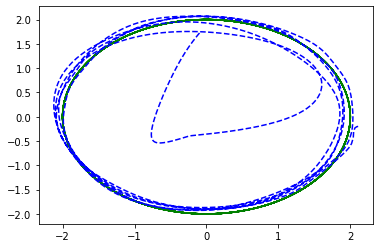

Iter 1250 | Total Loss 0.493138


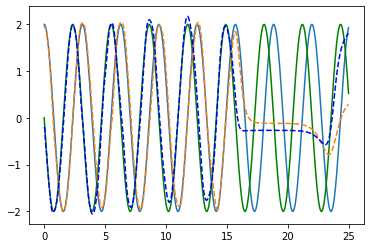

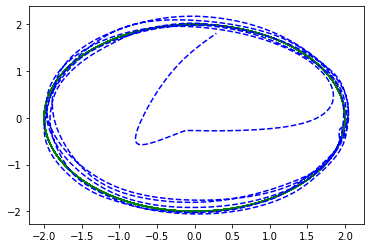

Iter 1300 | Total Loss 0.517864


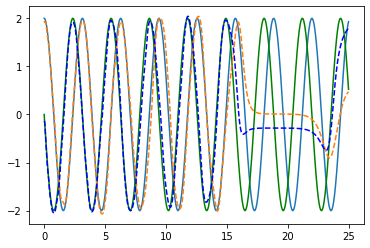

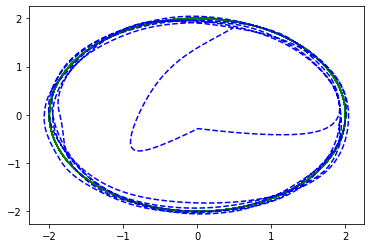

Iter 1350 | Total Loss 0.522985


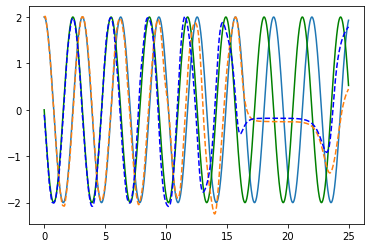

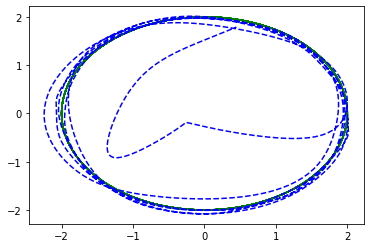

Iter 1400 | Total Loss 0.544418


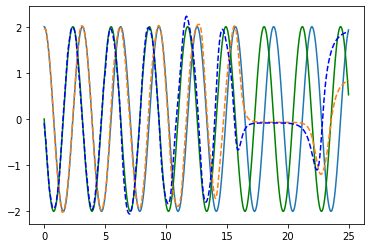

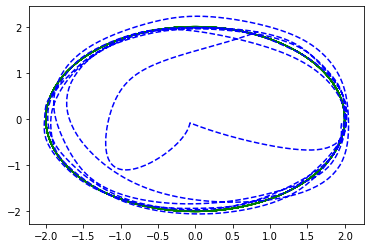

Iter 1450 | Total Loss 0.457308


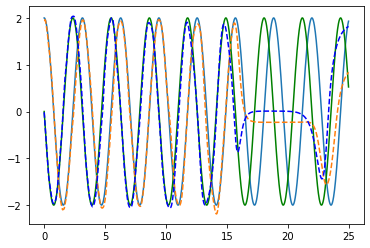

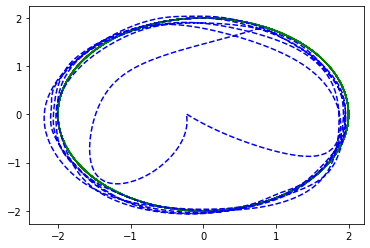

Iter 1500 | Total Loss 0.556731


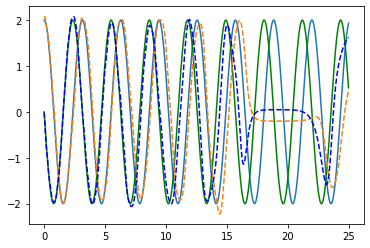

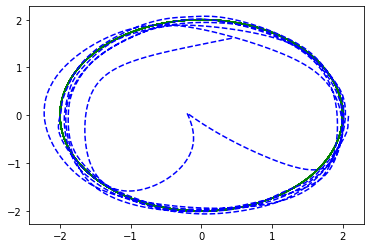

Iter 1550 | Total Loss 0.456818


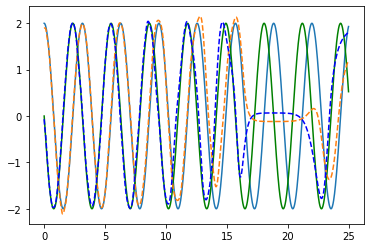

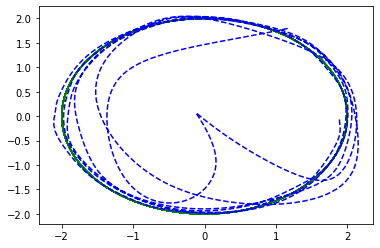

Iter 1600 | Total Loss 0.529919


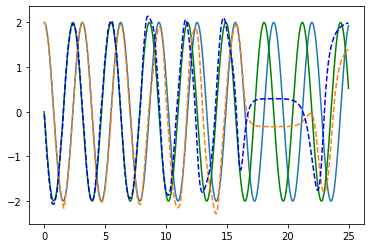

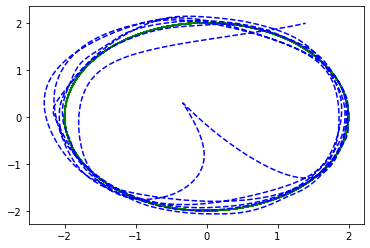

Iter 1650 | Total Loss 0.434167


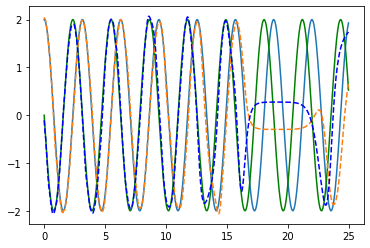

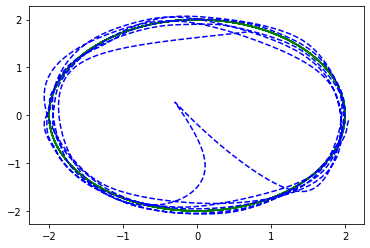

Iter 1700 | Total Loss 0.426629


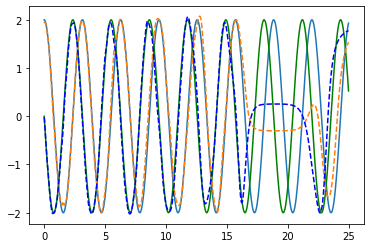

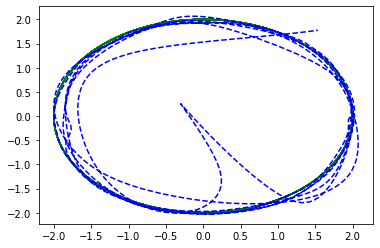

Iter 1750 | Total Loss 0.383569


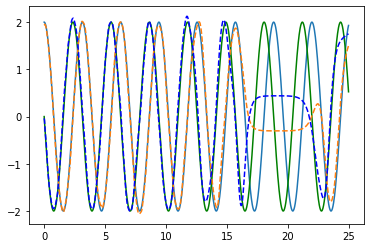

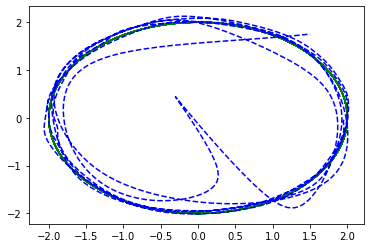

Iter 1800 | Total Loss 0.434196


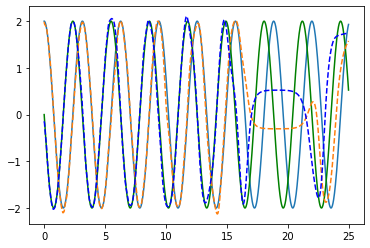

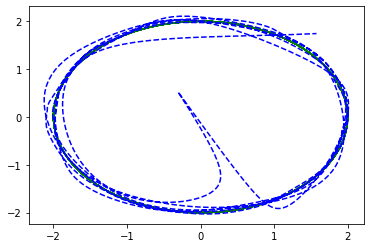

Iter 1850 | Total Loss 0.500230


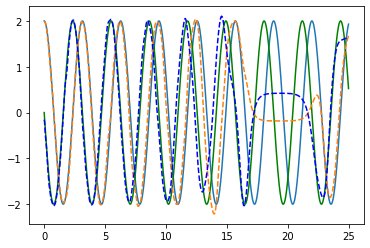

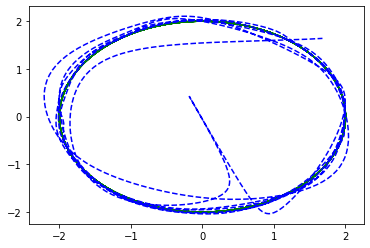

Iter 1900 | Total Loss 0.414692


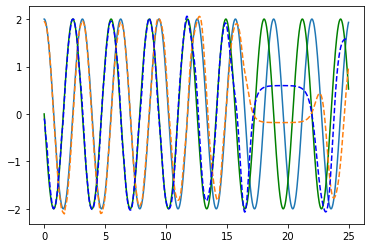

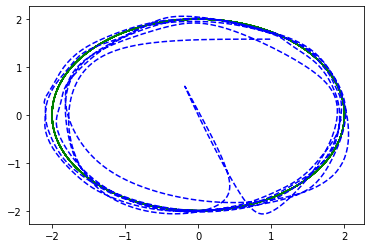

Iter 1950 | Total Loss 0.403415


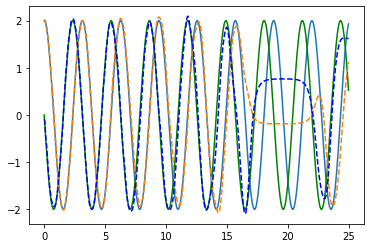

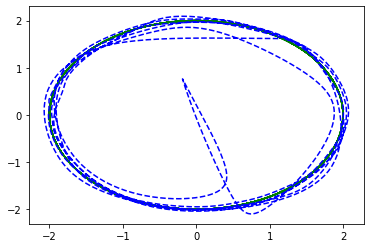

Iter 2000 | Total Loss 0.418074


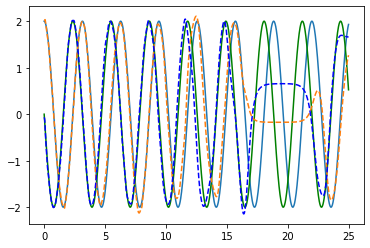

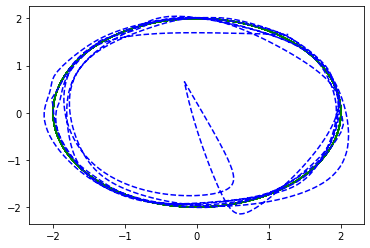

Iter 2050 | Total Loss 0.484956


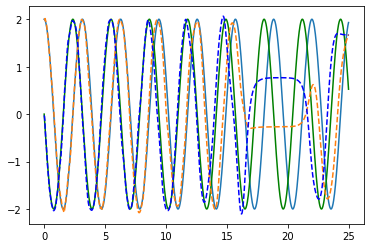

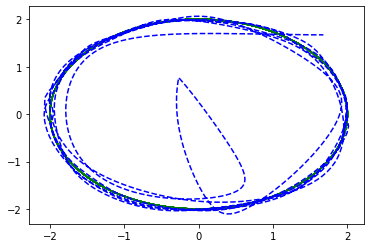

Iter 2100 | Total Loss 0.454347


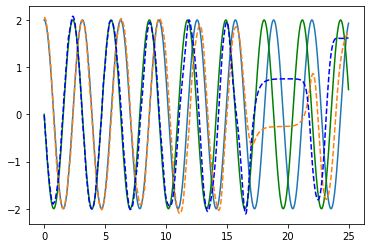

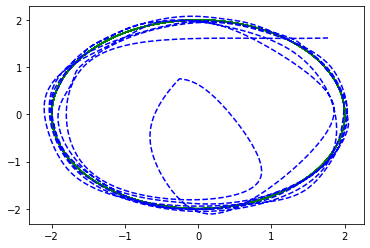

Iter 2150 | Total Loss 0.541831


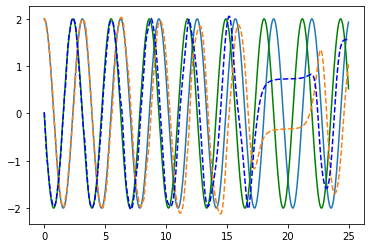

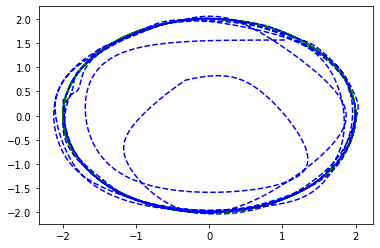

Iter 2200 | Total Loss 0.330353


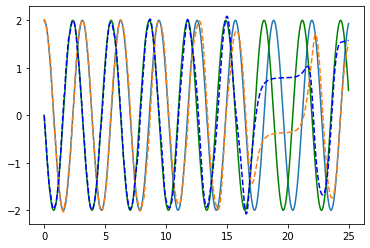

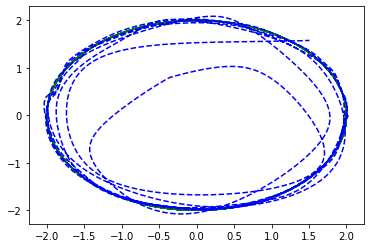

Iter 2250 | Total Loss 0.387109


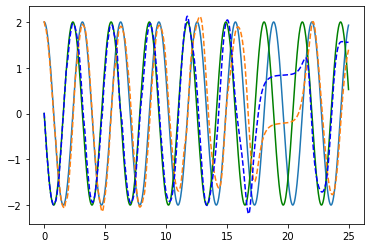

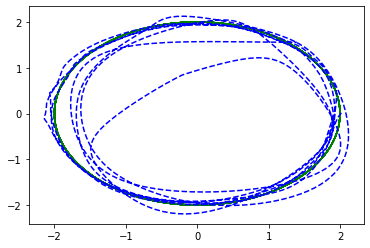

Iter 2300 | Total Loss 0.354517


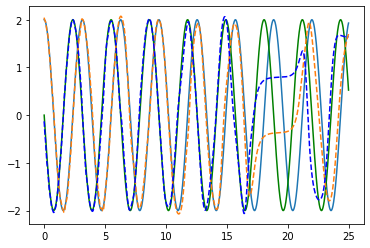

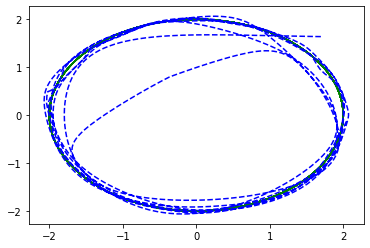

Iter 2350 | Total Loss 0.399081


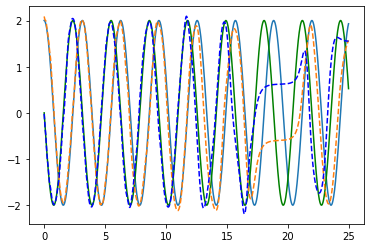

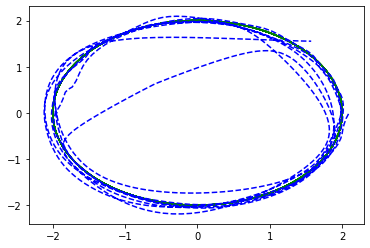

Iter 2400 | Total Loss 0.323654


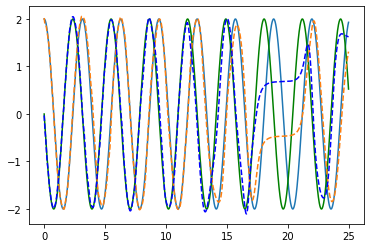

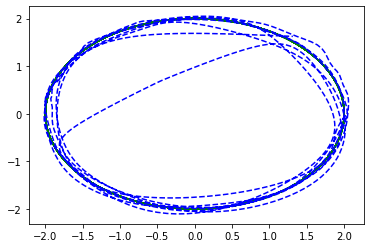

Iter 2450 | Total Loss 0.384171


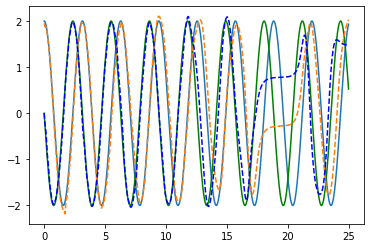

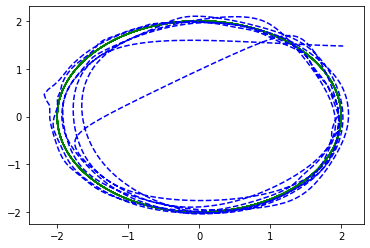

Iter 2500 | Total Loss 0.474345


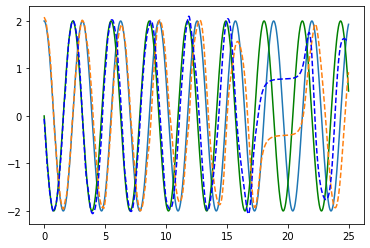

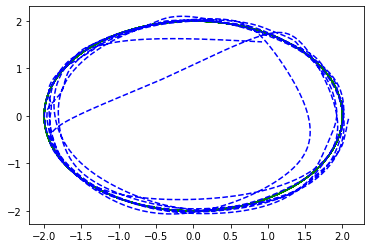

Iter 2550 | Total Loss 0.336848


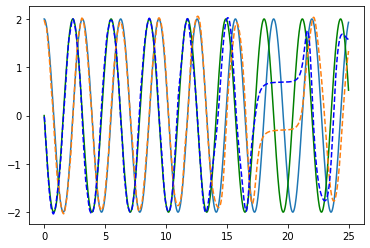

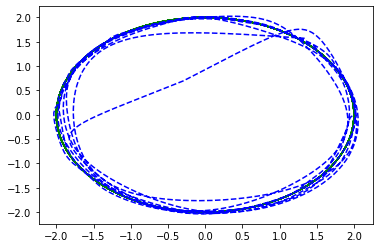

Iter 2600 | Total Loss 0.370189


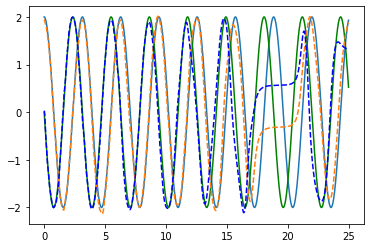

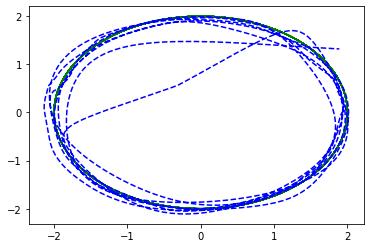

Iter 2650 | Total Loss 0.362074


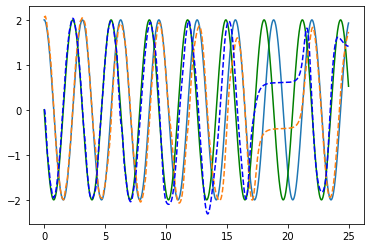

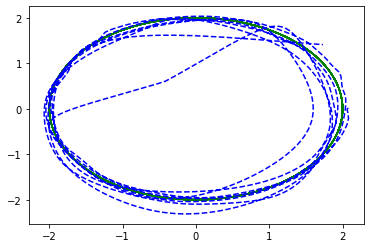

Iter 2700 | Total Loss 0.293843


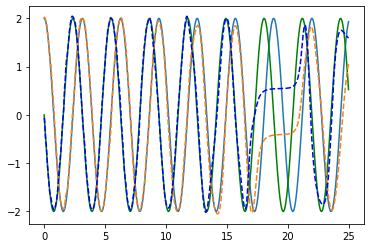

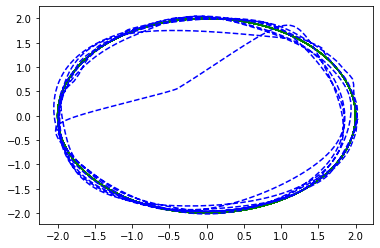

Iter 2750 | Total Loss 0.296600


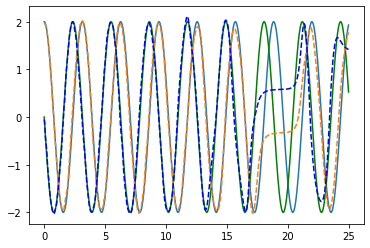

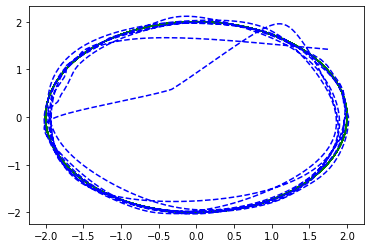

Iter 2800 | Total Loss 0.381025


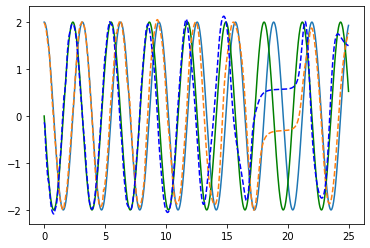

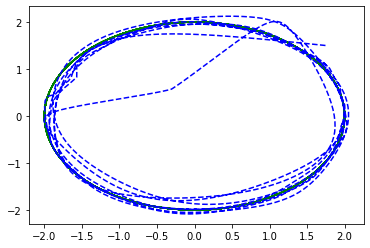

Iter 2850 | Total Loss 0.309123


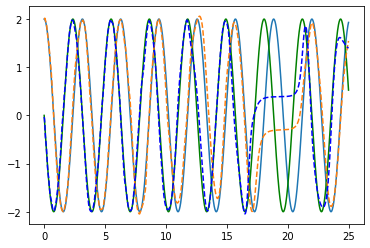

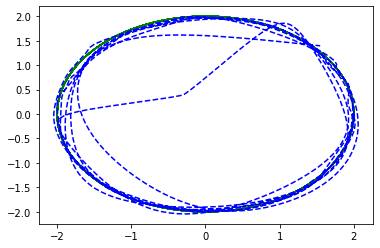

Iter 2900 | Total Loss 0.273631


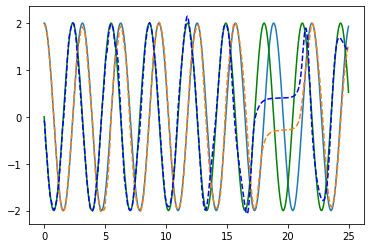

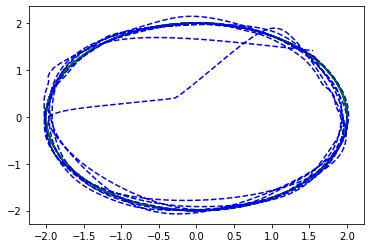

Iter 2950 | Total Loss 0.372703


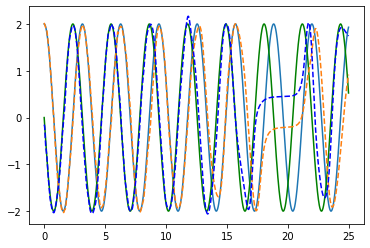

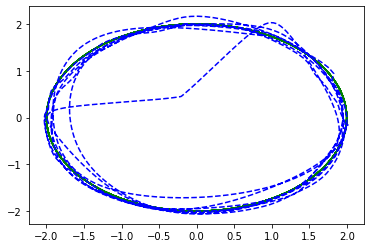

Iter 3000 | Total Loss 0.383753


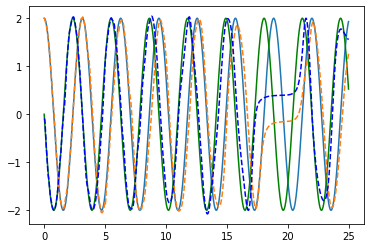

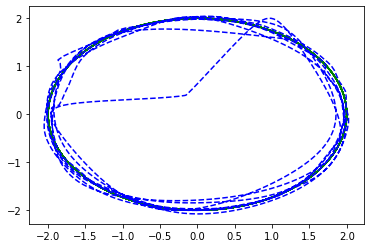

Iter 3050 | Total Loss 0.358294


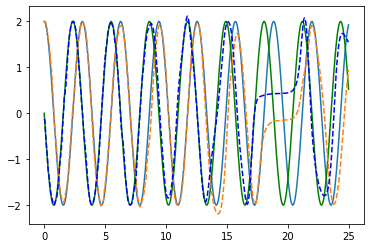

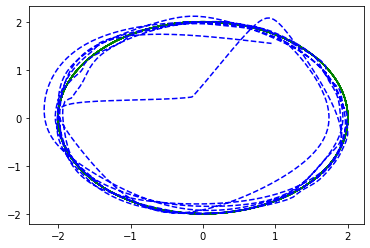

Iter 3100 | Total Loss 0.429488


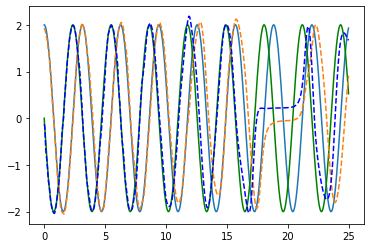

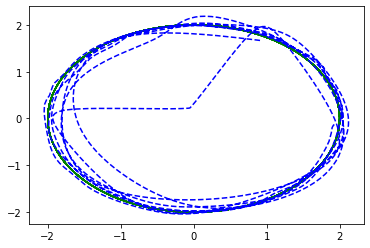

Iter 3150 | Total Loss 0.307779


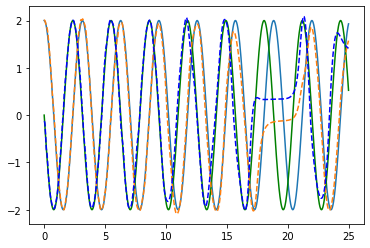

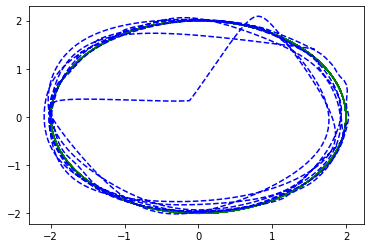

Iter 3200 | Total Loss 0.308364


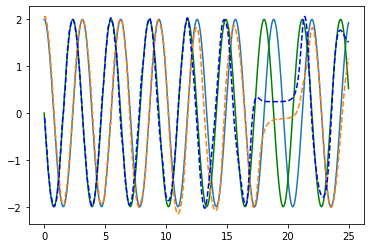

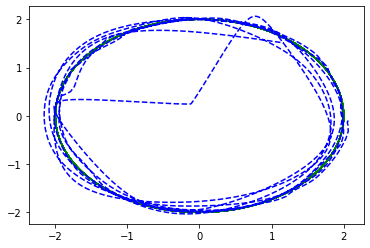

Iter 3250 | Total Loss 0.351882


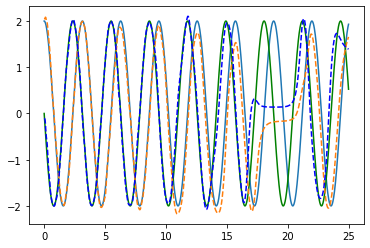

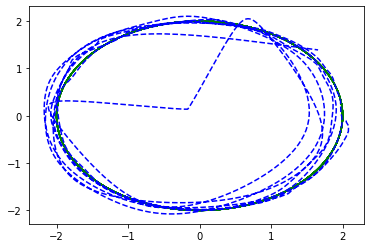

Iter 3300 | Total Loss 0.333415


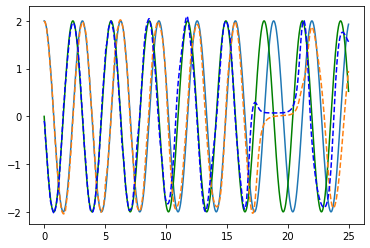

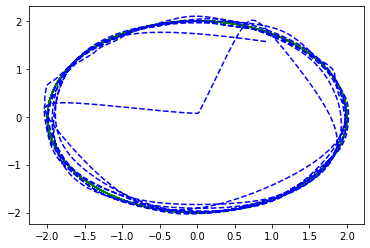

Iter 3350 | Total Loss 0.339384


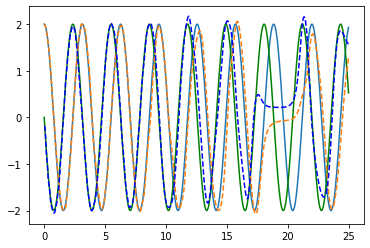

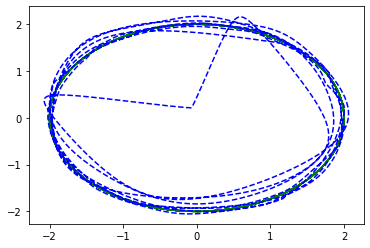

Iter 3400 | Total Loss 0.444026


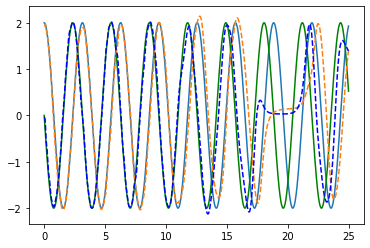

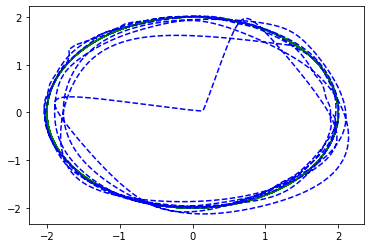

Iter 3450 | Total Loss 0.351161


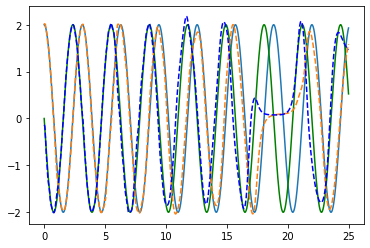

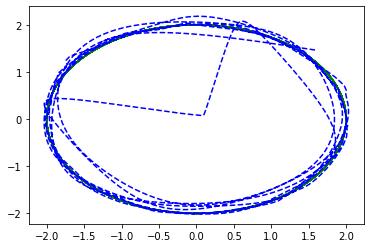

Iter 3500 | Total Loss 0.310170


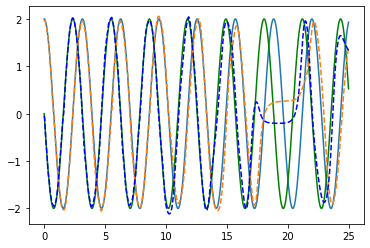

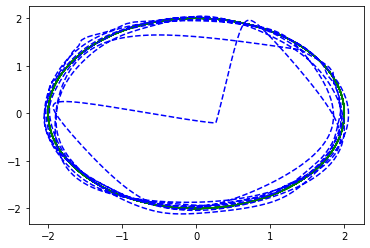

Iter 3550 | Total Loss 0.325446


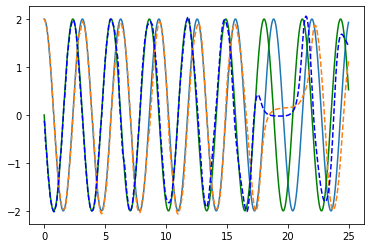

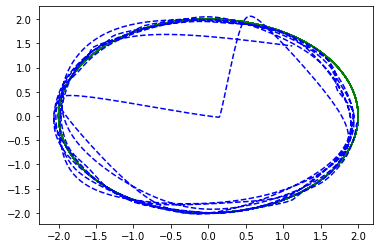

Iter 3600 | Total Loss 0.320802


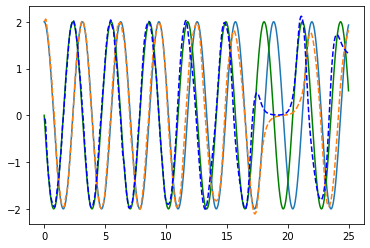

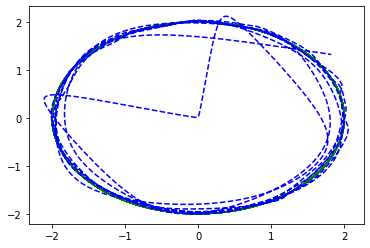

Iter 3650 | Total Loss 0.444535


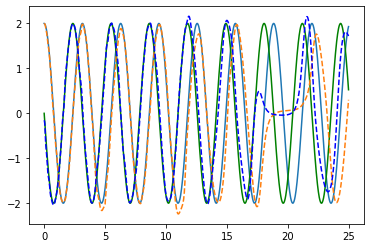

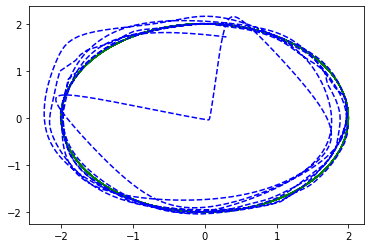

Iter 3700 | Total Loss 0.303165


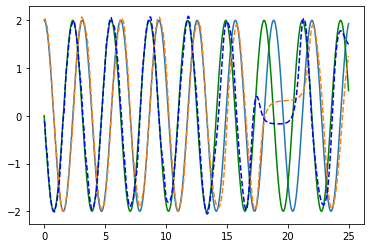

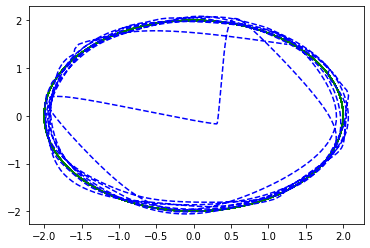

Iter 3750 | Total Loss 0.416382


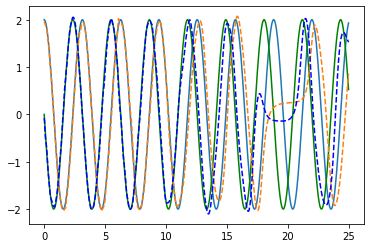

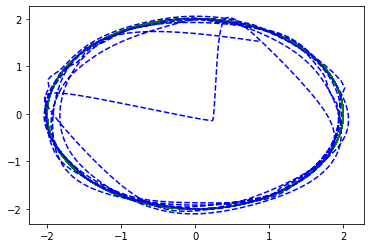

Iter 3800 | Total Loss 0.286704


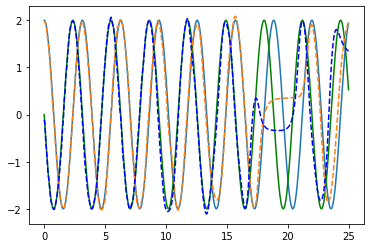

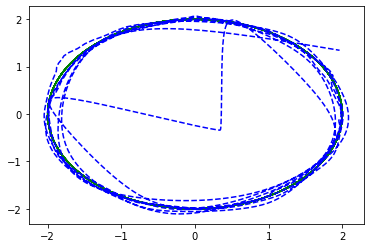

Iter 3850 | Total Loss 0.274832


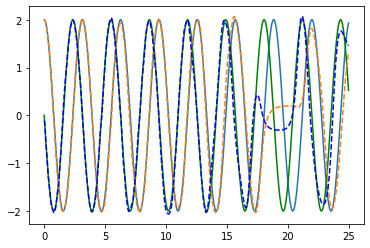

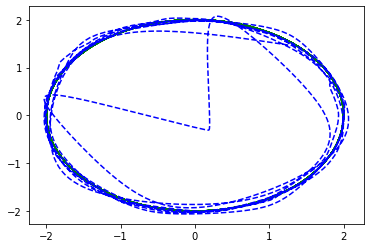

Iter 3900 | Total Loss 0.385777


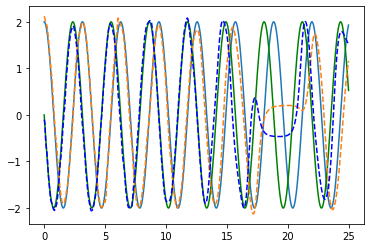

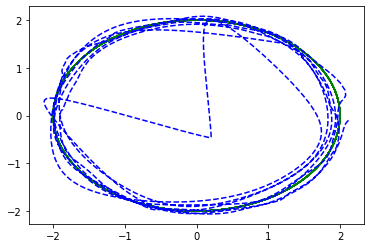

Iter 3950 | Total Loss 0.336934


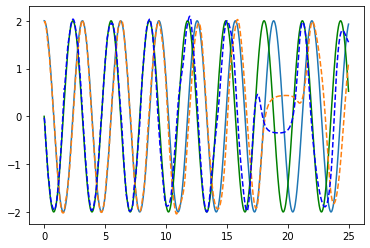

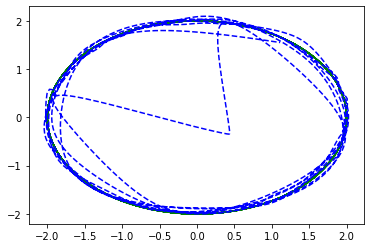

Iter 4000 | Total Loss 0.392796


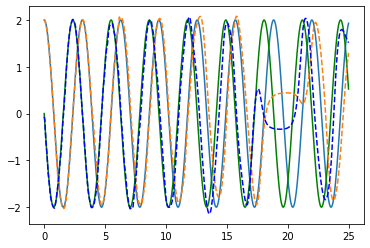

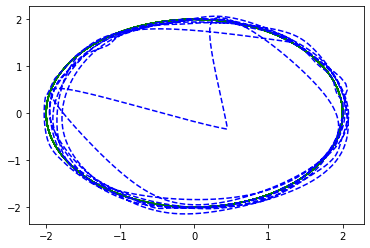

Iter 4050 | Total Loss 0.305011


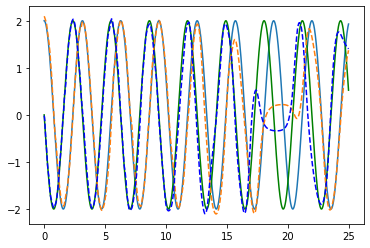

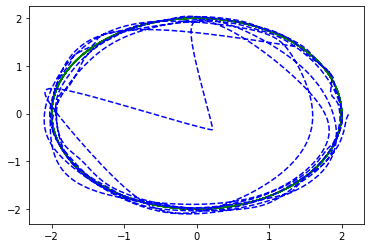

Iter 4100 | Total Loss 0.263441


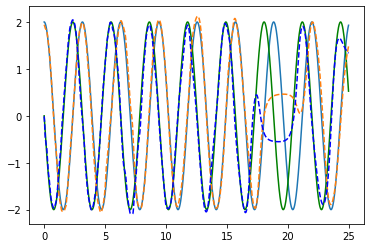

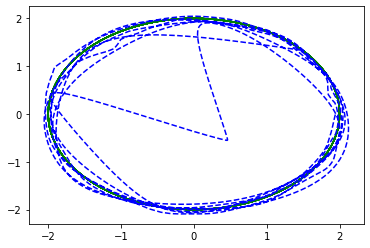

Iter 4150 | Total Loss 0.286952


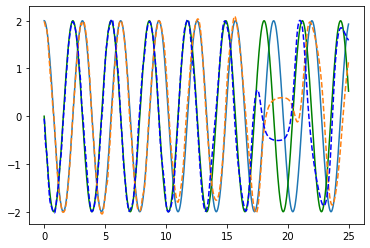

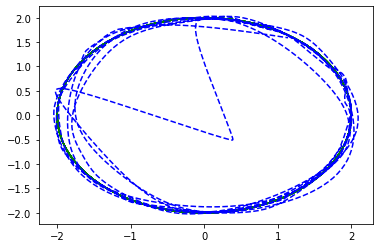

Iter 4200 | Total Loss 0.416512


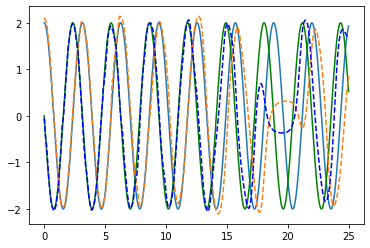

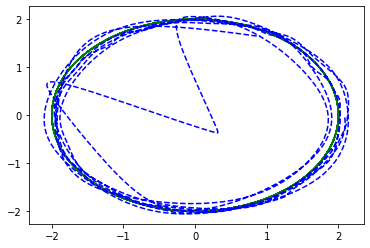

Iter 4250 | Total Loss 0.279297


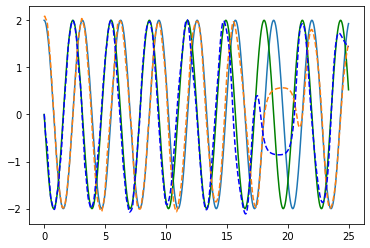

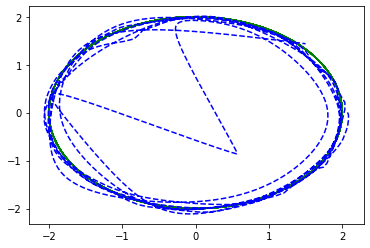

KeyboardInterrupt: ignored

In [ ]:

ii = 0
niters = 5000

func = Func()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

time_meter = RunningAverageMeter(0.97)
loss_meter = RunningAverageMeter(0.97)


for itr in range(1, niters + 1):
    permutation = torch.randperm(t.size()[0])
    itr -= 1
    for i in range(0, t.size()[0], batch_size):
        optimizer.zero_grad()
        indicies = permutation[i:i + batch_size]
        batch_t, batch_y = t[indicies], true_y[indicies]
        batch_t = batch_t.reshape(1, -1).t()
        pred_y = func(batch_t)
        pred_y = torch.reshape(pred_y, (20, 1, 2))
        loss = torch.mean(torch.abs(pred_y - batch_y))
        loss.backward()
        optimizer.step()
        itr += 1
        time_meter.update(time.time() - end)
        loss_meter.update(loss.item())

    if itr % 50 == 0:
        with torch.no_grad():
            pred_y = torch.rand((1000, 1, 2))
            for i in range(len(t)):
                pred_y[i] = func(torch.reshape(t[i], (1,)))
            loss = torch.mean(torch.abs(pred_y - true_y))
            print('Iter {:04d} | Total Loss {:.6f}'.format(itr, loss.item()))
            visualize(true_y, pred_y, func, ii)
            ii += 1

    end = time.time()


По моему, результат получился довольно интересным. Видно, что траектории меняются совершенно по другим
принципам, если сравнивать с ODENet. Но этой модели, к сожалению не удалось достаточно хорошо приблизить
исходную зависимость. Возможно, это можно исправить с помощью добавления новых слоев, но тогда количество тренируемых
параметров вырастет.

## Выводы

Таким образом, мы посмотрели как одинаковые по архитектуре, но разные по принципу обучения нейросети 
восстанавливали зависимость, заданную системой линейных дифференциальных уравнений. В ходе эксперимента получилось, 
что обучение с помощью *odenet* показало лучший результат. Правда, возможно, это связано с не совсем верным подбором
гиперпараметров, но, что есть — то есть. 

## Источники

Исходная статья - https://arxiv.org/abs/1806.07366

Авторский репозиторий - https://github.com/rtqichen/torchdiffeq
